In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
vdata = pd.read_csv(
    "2021VAERSDATA.csv", encoding="iso-8859-1",
    usecols=lambda name: name != "SYMPTOM_TEXT")

In [2]:
num_rows = len(vdata)
perc_nan = {}
for col_name in vdata.columns:
    num_nans = len(vdata[col_name][vdata[col_name].isna()])
    perc_nan[col_name] = 100 * num_nans / num_rows
labels = perc_nan.keys() #column names that we are analyzing
bar_values = list(perc_nan.values()) # fraction of null values
x_positions = np.arange(len(labels)) #location of the bars on the bar chart that we are going to plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


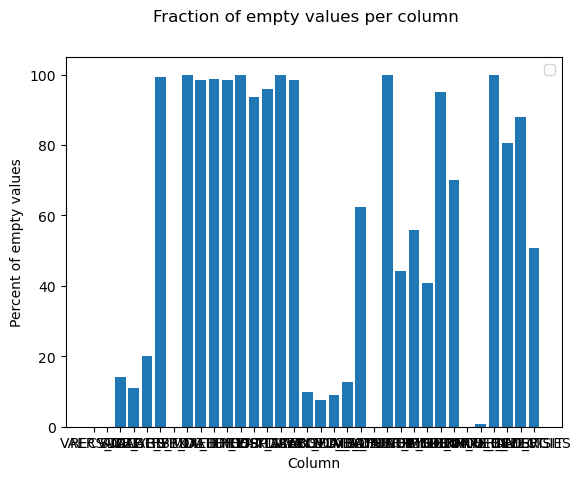

In [3]:
# first version of the bar plot
fig = plt.figure()
fig.suptitle("Fraction of empty values per column")
ax = fig.add_subplot()
ax.bar(x_positions, bar_values)
ax.set_ylabel("Percent of empty values")
ax.set_xlabel("Column")
ax.set_xticks(x_positions)
ax.set_xticklabels(labels)
ax.legend()
fig.savefig("naive_chart.png")

# sad result

In [4]:
fig = plt.figure(figsize=(16, 9), tight_layout=True, dpi=600)
fig.suptitle("Fraction of empty values per column", fontsize="48")
ax = fig.add_subplot()
b1 = ax.bar(x_positions, bar_values)
ax.set_ylabel("Percent of empty values", fontsize="xx-large") #tighter layout
ax.set_xticks(x_positions)
ax.set_xticklabels(labels, rotation=45, ha="right") #rotate the x-axis tick labels 45 degrees
ax.set_ylim(0, 100)
ax.set_xlim(-0.5, len(labels))
for i, x in enumerate(x_positions):
    ax.text(
        x, 2, "%.1f" % bar_values[i], rotation=90,
        va="bottom", ha="center",
        backgroundcolor="white")
fig.text(0.2, 0.01, "Column", fontsize="xx-large")
fig.savefig("cleaner_chart.png")

In [5]:
dead = vdata[vdata.DIED == "Y"]
vax = pd.read_csv("2021VAERSVAX.csv", encoding="iso-8859-1").set_index("VAERS_ID")
vax_dead = dead.join(vax, on="VAERS_ID", how="inner")
vax_dead.iloc[0]

VAERS_ID                                                      916803
RECVDATE                                                  01/01/2021
STATE                                                             LA
AGE_YRS                                                         78.0
CAGE_YR                                                         78.0
CAGE_MO                                                          NaN
SEX                                                                M
RPT_DATE                                                         NaN
DIED                                                               Y
DATEDIED                                                  10/18/2020
L_THREAT                                                           Y
ER_VISIT                                                         NaN
HOSPITAL                                                           Y
HOSPDAYS                                                         8.0
X_STAY                            

In [9]:
#Vaccines involved in deaths
dead_counts = vax_dead["VAX_TYPE"].value_counts()
large_values = dead_counts[dead_counts >= 10]
other_sum = dead_counts[dead_counts < 10].sum()
large_values = large_values.append(pd.Series({"OTHER": other_sum}))

In [10]:
#Days between administration and death
distance_df = vax_dead[vax_dead.DATEDIED.notna() & vax_dead.VAX_DATE.notna()]
distance_df["DATEDIED"] = pd.to_datetime(distance_df["DATEDIED"])
distance_df["VAX_DATE"] = pd.to_datetime(distance_df["VAX_DATE"])
distance_df = distance_df[distance_df.DATEDIED >= "2021"]
distance_df = distance_df[distance_df.VAX_DATE >= "2021"]
distance_df = distance_df[distance_df.DATEDIED >= distance_df.VAX_DATE]
time_distances = distance_df["DATEDIED"] - distance_df["VAX_DATE"]
time_distances_d = time_distances.astype(int) / (10**9 * 60 * 60 * 24)

In [11]:
#Deaths over time
date_died = pd.to_datetime(vax_dead[vax_dead.DATEDIED.notna()]["DATEDIED"])
date_died = date_died[date_died >= "2021"]
date_died_counts = date_died.value_counts().sort_index()
cum_deaths = date_died_counts.cumsum()

In [12]:
#Sex of people who have died for the top 10 states in terms of quantity.
state_dead = vax_dead[vax_dead["STATE"].notna()][["STATE", "SEX"]]
top_states = sorted(state_dead["STATE"].value_counts().head(10).index)
top_state_dead = state_dead[state_dead["STATE"].isin(top_states)].groupby(["STATE", "SEX"]).size()#.reset_index()
top_state_dead.loc["MN", "U"] = 0  # XXXX
top_state_dead = top_state_dead.sort_index().reset_index()
top_state_females = top_state_dead[top_state_dead.SEX == "F"][0]
top_state_males = top_state_dead[top_state_dead.SEX == "M"][0]
top_state_unk = top_state_dead[top_state_dead.SEX == "U"][0]

In [19]:
fig, ((vax_cnt, time_dist), (death_time, state_reps)) = plt.subplots(
    2, 2,
    figsize=(16, 9), tight_layout=True, dpi=600)

#vax_cnt
vax_cnt.set_title("Vaccines involved in deaths")
wedges, texts = vax_cnt.pie(large_values)
vax_cnt.legend(wedges, large_values.index, loc="lower left")

#time_dist
time_dist.hist(time_distances_d, bins=50)
time_dist.set_title("Days between vaccine administration and death")
time_dist.set_xlabel("Days")
time_dist.set_ylabel("Observations")

#death_time
death_time.plot(date_died_counts.index, date_died_counts, ".")
death_time.set_title("Deaths over time")
death_time.set_ylabel("Daily deaths")
death_time.set_xlabel("Date")

tw = death_time.twinx()
tw.plot(cum_deaths.index, cum_deaths)
tw.set_ylabel("Cummulative deaths")

#state_reps
state_reps.set_title("Deaths per state stratified by sex")
state_reps.bar(top_states, top_state_females, label="Females")
state_reps.bar(top_states, top_state_males, label="Males", bottom=top_state_females)
state_reps.bar(top_states, top_state_unk, label="Unknown",
               bottom=top_state_females.values + top_state_males.values)
state_reps.legend()
state_reps.set_xlabel("State")
state_reps.set_ylabel("Deaths")



Text(0, 0.5, 'Deaths')

In [21]:
fig.savefig("summary.png")